<a href="https://colab.research.google.com/github/himanshu230998/Lab-2-CS504-RNN-from-Scratch-and-Machine-translation/blob/main/Lab_2_(Himanshu_Kumar_Singh).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 
# Himanshu Kumar Singh
# 2017meb1212


# Basic Linear Recurrent Neural Network from Scratch (Total for this subsection: **30 points**)
---
This section aims to design a simple one hidden layer RNN from scratch to count the number of ones in a binary sequence ( e.g., number of ones in  [ 1, 1, 1, 0, 0, 1, 0, 0, 1, 1] is 6) 

In [ ]:
# Imports
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')
np.random.seed(seed=1)

# Synthetic Dataset

In [ ]:
# Following code snippet generates a binary sequence.  
num_samples = 20
sequence_len = 10
#Train Sequences
trainX = np.zeros((num_samples, sequence_len))
for row_idx in range(num_samples):
    trainX[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
print(trainX)

trainY = np.sum(trainX, axis=1)
print(trainY)

#Test Sequences
testX = np.zeros((5, sequence_len))
for row_idx in range(5):
    testX[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
print(testX)

testY = np.sum(testX, axis=1)
print(testY)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 0. 1. 1. 1.]
 [0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0. 0. 1. 1.]]
[2. 4. 6. 6. 4. 4. 6. 5. 7. 5. 7. 6. 4. 7. 3. 6. 4. 5. 6. 6.]
[[1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0. 1. 1.]]
[8. 4. 6. 5. 6.]


* Perform forward and backward pass.

In [ ]:
# Compute state k from the previous state (sk) and current input (xk), by use of the input weights (wx) and recursive weights (wRec)

def update_state(xk, sk, wx, wRec):
    return xk * wx + sk * wRec

# Performs the forward pass
def forward_states(X, wx, wRec):

    # S matrix  will holds all states for all input sequences
    S = np.zeros((X.shape[0], X.shape[1]+1))
    for k in range(0, X.shape[1]):
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S

# Performs the backward pass
def backward_gradient(X, S, grad_out, wRec):
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        wx_grad += np.sum(
            np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        wRec_grad += np.sum(
            np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

# Output gradient
def output_gradient(y, t):
    return 2. * (y - t)

* Use mean square error for computing loss and plot the mesh-grid of the loss surface (w_x vs. w_rec).
* On this loss surface, mark points (w_x, w_rec) that show exploding and vanishing gradients property.

In [ ]:
# mean square error
def loss(y, t): 
    return np.mean((t - y)**2)

In [ ]:
# Plotting functions

# Points to annotate (wx, wRec, color)
points = [(2,2,'k'),(2,1,'r'), (1,2,'w'), (1,1,'m'), (1,0,'c'), 
          (1,0.5,'g'), (1,-0.5,'b'),(-2,-2,'y')]

def get_loss_surface(w1_low, w1_high, w2_low, w2_high, 
                     nb_of_ws, loss_func):
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)  # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)  # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)  # Generate grid
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))  # Initialize loss matrix
    # Fill the loss matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i,j] = loss_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, loss_ws


def plot_surface(ax, ws1, ws2, loss_ws):
    """Plot the loss in function of the weights."""
    surf = ax.contourf(
        ws1, ws2, loss_ws, levels=np.logspace(-0.2, 8, 30), 
        cmap=cm.viridis, norm=LogNorm())
    ax.set_xlabel('$w_{x}$', fontsize=12)
    ax.set_ylabel('$w_{rec}$', fontsize=12)
    return surf

def plot_points(ax, points):
    """Plot the annotation points on the given axis."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

        
def get_loss_surface_figure(loss_func, points):
    """Plot the loss surfaces together with the annotated points."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))   
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 100, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        -0.1, 2.1, -0.1, 2.1, 100, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(-0.1, 2.1)
    ax_2.set_ylim(-0.1, 2.1)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Loss surface', fontsize=15)
    return fig

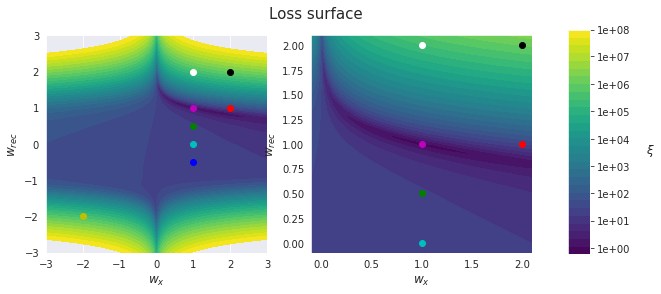

In [ ]:
# loss surface and gradients
fig = get_loss_surface_figure(
    lambda w1, w2: loss(forward_states(trainX, w1, w2)[:,-1] , trainY), points)

*  Give an insight into the instability of gradients during backward propagation on a graph. Plot a graph between gradients of loss w.r.t hidden state at time t (Y-axis) and timestamps t (X-axis). Note that you have to plot for various (w_x, w_rec) showing peculiar properties from the previous question. Mark your observations. 

------
* Answer: We observe that when |$w_{rec}$| > 1, exploding gradient is observed as illustrated ($w_{rec}$=2, $w_x$=2, black line), ($w_{rec}$=-2, $w_x$=2, yellow line) and when |$w_{rec}$| < 1, vanishing gradient is observed as illustrated ($w_{rec}$=0.5, $w_x$=1, green line), ($w_{rec}$=-0.5, $w_x$=1, dark blue line). When $w_{rec}$ = 1 (illutrated as ($w_{rec}$=1, $w_x$=2, red line) and ($w_{rec}$=1, $w_x$=1, magenta line), ($w_{rec}$=2, $w_x$=2, black line)), gradient stay constant over time and when $w_{rec}$ = 0 (illutrated as ($w_{rec}$=0, $w_x$=1, light blue line)), gradient quickly comes to 0.

It is because the gradient of a state $S_k$ between a state $m$ timesteps back ($S_{k-m}$) can then be written as:

$$
\frac{\partial S_{k}}{\partial S_{k-m}} 
= \frac{\partial S_{k}}{\partial S_{k-1}} \cdot \cdots \cdot \frac{\partial S_{k-m+1}}{\partial S_{k-m}} = w_{rec}^m
$$

This is the reason that $w_{rec}$ is less than 1, it tends to 0 as m increases and learning get stop since weights cannot significantly changed in backpropagation step. When  $w_{rec}$ is negative, gradient changes sign(positive when m even and vice versa ) 



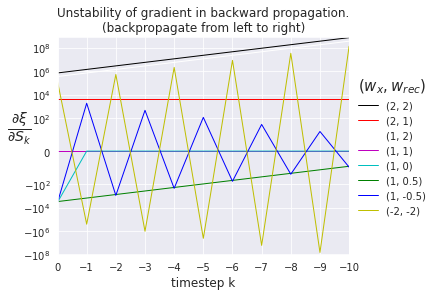

In [ ]:
def plot_gradient_over_time(points, get_grad_over_time):
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(
            x, np.sum(grad_over_time, axis=0), c+'-', 
            label=f'({wx}, {wRec})', linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4, 
                -10**6, -10**8])
    plt.xlabel('timestep k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', 
               fontsize=20, rotation=0)
    plt.title(('Unstability of gradient in backward propagation.'
               '\n(backpropagate from left to right)'))
    leg = plt.legend(
        loc='center left', bbox_to_anchor=(1, 0.5), 
        frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})
    fig.subplots_adjust(right=0.8)
    

def get_grad_over_time(wx, wRec):
    S = forward_states(trainX, wx, wRec)
    grad_out = output_gradient(S[:,-1], trainY).sum()
    _, grad_over_time = backward_gradient(trainX, S, grad_out, wRec)
    return grad_over_time

# Get the plots of the gradients changing by backpropagating.
plot_gradient_over_time(points, get_grad_over_time)
plt.show()

* Use Rprop (Resilient Propagation) as an optimization algorithm; you can use the library (if any) for this part
Plot the optimization trajectory on the loss surface

In [ ]:
# Define Rprop optimisation function
def update_rprop(trainX, trainY, W, W_prev_sign, W_delta, eta_p, eta_n):
 
    # Perform forward and backward pass to get the gradients
    S = forward_states(trainX, W[0], W[1])
    grad_out = output_gradient(S[:,-1], trainY)
    W_grads, _ = backward_gradient(trainX, S, grad_out, W[1])
    W_sign = np.sign(W_grads)  # Sign of new gradient
    # Update the Delta (update value) for each weight 
    #  parameter seperately
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign
# Perform Rprop optimisation
 
# Set hyperparameters
eta_p = 1.2
eta_n = 0.5
 
# Set initial parameters
W = [-1.5, 2]  # [wx, wRec]
W_delta = [0.001, 0.001]  # Update values (Delta) for W
W_sign = [0, 0]  # Previous sign of W
 
ls_of_ws = [(W[0], W[1])]  # List of weights to plot
# Iterate over 500 iterations
for i in range(500):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = update_rprop(
        trainX, trainY, W, W_sign, W_delta, eta_p, eta_n)
    # Update each weight parameter seperately
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))  # Add weights to list to plot
 
print(f'Final weights are: wx = {W[0]:.4f},  wRec = {W[1]:.4f}')

Final weights are: wx = 1.0014,  wRec = 0.9997


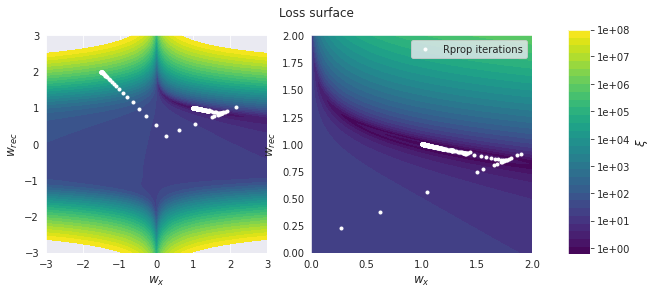

In [ ]:
# Plot the loss surface with the weights over the iterations.

# Define plot function
def plot_optimisation(ls_of_ws, loss_func):
    """Plot the optimisation iterations on the loss surface."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1, 2, 1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 100, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    ax_1.plot(ws1, ws2, 'wo', markersize=3)
    ax_1.set_xlim([-3, 3])
    ax_1.set_ylim([-3, 3])
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1, 2, 2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        0, 2, 0, 2, 100, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    ax_2.set_xlim([0, 2])
    ax_2.set_ylim([0, 2])
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2)
    ax_2.plot(ws1, ws2, 'wo', 
              label='Rprop iterations', markersize=3)
    ax_2.legend()
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=12)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Loss surface', fontsize=12)
    plt.show()
    
# Plot the optimisation
plot_optimisation(
    ls_of_ws, lambda w1, w2: loss(forward_states(trainX, w1, w2)[:,-1] , trainY))
plt.show()
#

* Is your RNN well trained? Does it count the number of ones in the binary list well? How significant a change is observed in model training by introduction of Resilient Propoagation? 

------
* Answer: Our RNN model is well trained since mean squared error is very low. Yes, it counts very well numbers of 1's in binary sequence and if we round off our output, it will exacty the same as the count. Resilient Propoagation have worked very well with the given hyperparmeter.




In [ ]:
print(f'Final weights are: wx = {W[0]:.4f},  w_rec = {W[1]:.4f}')
print ("Real: \t\t", testY)

y = forward_states(testX, W[0],W[1])

print ("Predicted: \t",y[:,-1])
print("MSE loss = ",loss(testY, y[:,-1]))

Final weights are: wx = 1.0014,  w_rec = 0.9997
Real: 		 [8. 4. 6. 5. 6.]
Predicted: 	 [7.99912058 4.00053639 6.00292046 4.99993836 5.99999099]
MSE loss =  1.9188076294620406e-06


# Machine Translation
---
In this section we will use the modified RNN's (LSTM or GRU) which can overcome the shortcomings of the multi layer Vanilla RNN for the Machine Translation task. We will be using the Hindi - English sentence pairs dataset for this exercise. The dataset can be downloaded from [Kaggle link](https://www.kaggle.com/kkhandekar/hindi-english-sentence-pairs) 

# To do

---
## Data Preprocessing

---






In [ ]:
#All import
import warnings
warnings.simplefilter("ignore")
import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

1. For ease of implementation, convert all English characters to either lower case or upper case 
2. Replace punctuations by spaces
3. Add \<start\> token to the begin of each sentence (both English and Hindi) 
4. Add \<end\> token to the end of each sentence (both English and Hindi) 


In [ ]:
import re
def stoi(a):
  q=list((a))
  l=len(q)
  for i in range(l):
    #Removing Punctuation
    if (q[i]==',' or q[i]=='.' or q[i]=='!' or q[i]=='"' or q[i]=='?' or q[i]=='\''):
      q[i]=' '
    if(q[i]=='C'):
      if(q[i+1]=='C'):
        if(q[i+2]=='-'):
          if(q[i+3]=='B'):
            if(q[i+4]=='Y'):
              break
  p=q[0:i-2]
  t = ''.join(map(str, p))
  #Lowercase
  t = t.lower()
  t=re.compile(r'(\S)').split(t)
  t=t[:-1]
  t.append(' <end>\n')
  t.insert(0,'<start> ')
  if (' \t' in t):
    index=t.index(' \t')
    t[index]='\t'
  elif('  \t ' in t):
    index=t.index('  \t ')
    t[index]='\t'
  else:
    index=t.index('  \t')
    t[index]='\t'
  t.insert(index,' <end>')
  t.insert(index+2,'<start> ')
  t="".join(t)
  print(t)
  return(t)
            
fin = open('/content/drive/My Drive/Colab Notebooks/input.txt',"r")
fout = open('/content/drive/My Drive/Colab Notebooks/output.txt', "w+")
for line in fin:
  fout.write(stoi(line))
fin.close()
fout.close()

Streaming output truncated to the last 5000 lines.

<start> this is your dog <end>	<start> यह तुम्हारा कुत्ता है <end>

<start> this is your key <end>	<start> यह आपकी चाबी है <end>

<start> this isn t right <end>	<start> यह सही नहीं है <end>

<start> tom is my friend <end>	<start> टॉम मेरा दोस्त है <end>

<start> we re going home <end>	<start> हम घर जा रहें हैं <end>

<start> we re in a hurry <end>	<start> हम जल्दी में हैं <end>

<start> what is your age <end>	<start> तुम्हारी उम्र क्या है <end>

<start> what s that bird <end>	<start> वह कौनसी चिड़िया है <end>

<start> what s the story <end>	<start> क्या कहानी है <end>

<start> what s your name <end>	<start> आपका नाम क्या है <end>

<start> where did you go <end>	<start> तुम कहाँ गए थे <end>

<start> where is the bar <end>	<start> शराबख़ाना कहाँ है <end>

<start> whose turn is it <end>	<start> किसकी बारी है <end>

<start> you may be right <end>	<start> तुम शायद सही हो <end>

<start> are your eyes bad <end>	<start> तुम्हारी आँखे खराब हैं

In [ ]:
input_texts = []
target_texts = []
with open('/content/drive/My Drive/Colab Notebooks/output.txt', "r", encoding="utf-8") as f:
    for line in f.readlines():  
      input_text,target_text= line.split("\t")
      input_texts.append(input_text)
      target_texts.append(target_text)
f.close()

5. Use \<pad\> token so that all statements of a language has same length

In [ ]:
maxe=0
for i in range(len(input_texts)):
  t=len(input_texts[i].split( ))
  if(t>maxe):
    maxe=t
print(maxe)
for i in range(len(input_texts)):
  t=input_texts[i].split( )
  ind=len(t)
  for j in range(maxe-ind):
    t.insert(ind-1,' <pad> ')
  input_texts[i]=""
  input_texts[i]=" ".join(t)
print(input_texts)

25
['<start> wow  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> help  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> jump  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> jump  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> jump  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start

In [ ]:
maxh=0
for i in range(len(target_texts)):
  t=len(target_texts[i].split( ))
  if(t>maxe):
    maxh=t
print(maxh)
for i in range(len(target_texts)):
  t=target_texts[i].split( )
  ind=len(t)
  for j in range(maxh-ind):
    t.insert(ind-1,' <pad> ')
  target_texts[i]=""
  target_texts[i]=" ".join(t)
print(target_texts)

27
['<start> वाह  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> बचाओ  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> उछलो  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> कूदो  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>  <end>', '<start> छलांग  <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>

6. Use a built in library tokenizer to convert words to tokens (numeric representation) (both English and Hindi)

In [ ]:
import tensorflow as tf
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)
  return tensor, lang_tokenizer

In [ ]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)
print(inp_lang_tokenizer,"\n")

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

7. Convert a random instance from token sequence into words and display the human readable words (both English and Hindi)

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
print ("Input Language; index to word mapping")
convert(inp_lang_tokenizer, input_tensor_train[0])

print ("Target Language; index to word mapping")
convert(targ_lang_tokenizer, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
15 ----> my
255 ----> sister
140 ----> always
1887 ----> keeps
36 ----> her
111 ----> room
347 ----> clean
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
3 ----> <end>
Target Language; index to word mapping
2 ----> <start>
35 ----> मेरी
344 ----> बहन
36 ----> अपने
192 ----> कमरे
14 ----> को
152 ----> हमेशा
858 ----> साफ़-सुथरा
2308 ----> रखती
4 ----> है
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
1 ----> <pad>
3 ----> <end>



8. Split the dataset in 80%/20% split to get train and test sets

In [ ]:
from sklearn.model_selection import train_test_split
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

2219 2219 555 555


## Model Architecture

---

In general machine translation systems use two RNN's commonly called as Encoder and Decoder. Encoder works on the input language sequence and converts it into a hidden representation on which decoder works. Decoder is responsible for generating the target language sequence. Attention mechanism is used to learn which parts of the input sequence is to be looked at in order to generate the translation in the target language. 

**Note:** You may use LSTM or GRU or any special layers of your choice

## Translator Model 
---

1. We will be doing a English to Hindi translation task
2. Design a suitable encoder architecture to process the input sequences in English



In [ ]:
#length of input tensor train
BUFFER_SIZE = len(input_tensor_train)
#batch size
BATCH_SIZE = 64
#steps taken in each epochs
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
#total embedding dimensions of tensor
embedding_dim = 256
units = 1024
#vocabulary size of input and target
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

#tf.data.Dataset.from_tensor.slices
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 25]), TensorShape([64, 27]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    #The super() builtin returns a proxy object that allows you to refer parent class by 'super'.
    #https://www.programiz.com/python-programming/methods/built-in/super
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
#calling the initialize_hidden_state function
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 25, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


3. Use the attention Mechanism by Bahdanau et al. [1] to learn the effective alignment between English and Hindi sequences **(15 points)**

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 25, 1)


4. Design a suitable decoder architecture which can generate the target Hindi sequence based on the soft aligned English sequence

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2852)


5. Train the encoder-decoder sequence based on the cross entropy loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  #if (epoch + 1) % 2 == 0:
    #checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.1151
Epoch 1 Loss 0.1330
Time taken for 1 epoch 6.793904542922974 sec

Epoch 2 Batch 0 Loss 0.1238
Epoch 2 Loss 0.1369
Time taken for 1 epoch 6.728165864944458 sec

Epoch 3 Batch 0 Loss 0.1224
Epoch 3 Loss 0.1307
Time taken for 1 epoch 6.770299911499023 sec

Epoch 4 Batch 0 Loss 0.1405
Epoch 4 Loss 0.1343
Time taken for 1 epoch 6.82989501953125 sec

Epoch 5 Batch 0 Loss 0.1072
Epoch 5 Loss 0.1180
Time taken for 1 epoch 6.846189737319946 sec

Epoch 6 Batch 0 Loss 0.1032
Epoch 6 Loss 0.1145
Time taken for 1 epoch 6.862058401107788 sec

Epoch 7 Batch 0 Loss 0.1507
Epoch 7 Loss 0.1194
Time taken for 1 epoch 6.841324090957642 sec

Epoch 8 Batch 0 Loss 0.1097
Epoch 8 Loss 0.1105
Time taken for 1 epoch 6.803668022155762 sec

Epoch 9 Batch 0 Loss 0.0952
Epoch 9 Loss 0.1050
Time taken for 1 epoch 6.811291217803955 sec

Epoch 10 Batch 0 Loss 0.1478
Epoch 10 Loss 0.1432
Time taken for 1 epoch 6.8064398765563965 sec

Epoch 11 Batch 0 Loss 0.1503
Epoch 11 Loss 0.1295
Time tak

In [ ]:
#text preprocessing
def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)
    print(inp_lang_tokenizer.word_index[i] for i in sentence.split(' '))
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<pad>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
%matplotlib inline
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

<generator object evaluate.<locals>.<genexpr> at 0x7f2754c958e0>
Input: <start> i love my mother <end>
Predicted translation: मैं अपनी जान हूँ <pad> 


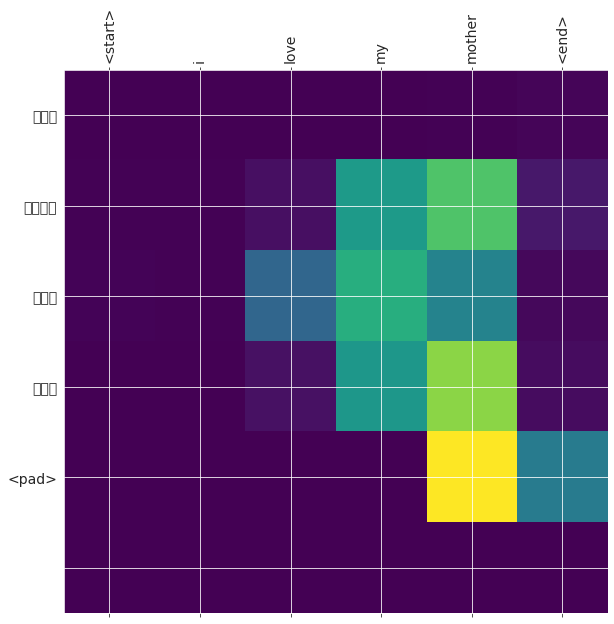

In [ ]:
translate("i love my mother")

<generator object evaluate.<locals>.<genexpr> at 0x7f27cc2d7e08>
Input: <start> you look happy today <end>
Predicted translation: तुम आज खुश लगते हो <pad> 


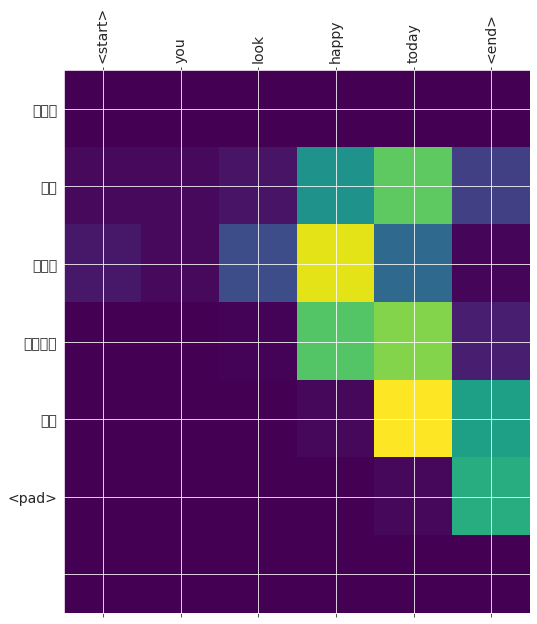

In [ ]:
translate("you look happy today")

<generator object evaluate.<locals>.<genexpr> at 0x7f27cc2d79e8>
Input: <start> he got a lot of money <end>
Predicted translation: वह अपने भाई एक बहुत अकेलापन महसूस हुआ है <pad> 


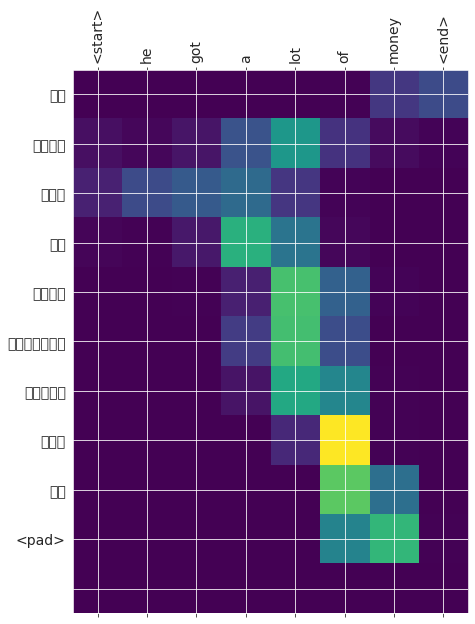

In [ ]:
translate("he got a lot of money")

<generator object evaluate.<locals>.<genexpr> at 0x7f27553a37d8>
Input: <start> i hate him <end>
Predicted translation: मुझे उसके आने से नहीं आ रहा है <pad> 


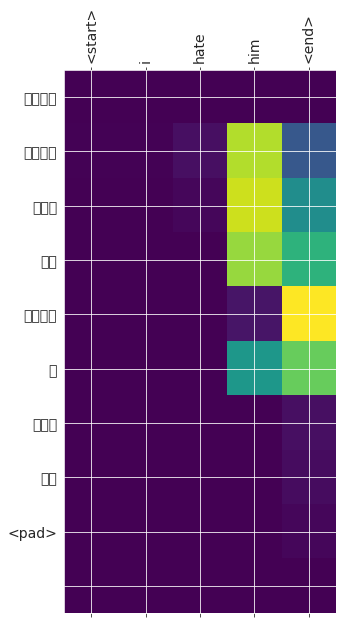

In [ ]:
translate("i hate him")

6. Use the BLEU score metric (pre defined library implementations in Python may be used) and discuss the goodness of the learned translator model

* Answer: I have tried many translation. It predicts little bit good if I give something from the data on which it is trained. It give very absurd result with grammertical mistake when something new is given. So even if bleu score is good for some translation, but the model has not grasped the translation of english to hindi in reasonable sense

In [ ]:
import nltk
# from above translation, we see take hypothesis and reference
hypothesis = ['I', 'love', 'my', 'mother']
reference = ['I', 'am', 'my','love']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

hypothesis = ['he','got','a', 'lot','of','money']
reference = ['he', 'his', 'brother','feel', 'lonely']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

hypothesis = ['I','hate','him']
reference = ['I', 'dont','his', 'come']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

0.9306048591020996
0.6389431042462724
0.5444460596606694
